In [90]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from itertools import islice
import torch.nn.functional as F
import torch.nn as nn

train_set = pd.read_csv('/content/sample_data/mnist_train_small.csv')
test_set = pd.read_csv('/content/sample_data/mnist_test.csv')

In [91]:
print(torch.__version__)

print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
 device = torch.device("cuda:0")
else:
 device = "cpu"
print(device)


2.0.1+cu118
GPU Available: True
cuda:0


In [92]:
train_value = train_set.values

training = torch.tensor(train_value)

label = training.T[0]
train_set = training.T[1:]
train_set = train_set.T
train_set_res = train_set.view(19999,1,28,28)

label = label.reshape(-1,1)

In [93]:
test_value = test_set.values

testing = torch.tensor(test_value)

label_test = testing.T[0]
test_set = testing.T[1:]

test_set = test_set.T
test_set_res = test_set.view(test_set.shape[0],1,28,28)
print(test_set_res.shape)


label_test = label_test.reshape(-1,1)

print(label_test.shape)


torch.Size([9999, 1, 28, 28])
torch.Size([9999, 1])


In [94]:
label_test = label_test.squeeze(1)

In [95]:
join_dataset = torch.utils.data.TensorDataset(train_set_res,label.squeeze(1))

final_train = DataLoader(join_dataset,batch_size = 64,drop_last=True)

example,label = next(iter(final_train))
print(example.shape)
print(label.shape)



torch.Size([64, 1, 28, 28])
torch.Size([64])


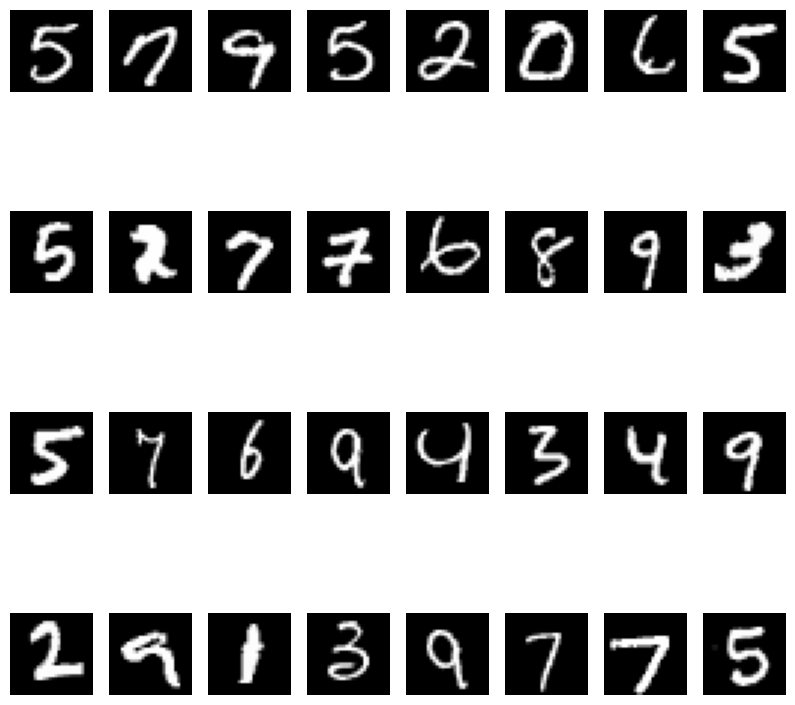

In [96]:
fig, axes = plt.subplots(4, 8, figsize=(10, 10))

for i in range(32):
    ax = axes[i // 8, i % 8]
    ax.imshow(example[i,0], cmap='gray')
    ax.axis('off')

plt.show()

In [107]:
from torch.nn.modules.flatten import Flatten
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      nn.Conv2d(1,32,5,1,2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2),
      nn.Conv2d(32,64,5,1,2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2),
      nn.Flatten(),
      nn.Linear(3136, 1024),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(1024, 10)
    )
  def forward(self, x):
    output = self.network(x)
    return output

In [108]:
model = Model()

In [110]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [116]:
def train(model, num_epochs, final_train):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in final_train:
      pred = model(x_batch.float())
    # print(pred.shape)
    # print(y_batch.shape)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = (
      torch.argmax(pred, dim=1) == y_batch
      ).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(final_train.dataset)
    accuracy_hist_train[epoch] /= len(final_train.dataset)

    model.eval()
    print(f'Epoch {epoch+1} accuracy: ' f'{accuracy_hist_train[epoch]:.4f}')
  return loss_hist_train, accuracy_hist_train

In [118]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs,final_train)

Epoch 1 accuracy: 0.9746
Epoch 2 accuracy: 0.9717
Epoch 3 accuracy: 0.9752
Epoch 4 accuracy: 0.9795
Epoch 5 accuracy: 0.9842
Epoch 6 accuracy: 0.9829
Epoch 7 accuracy: 0.9799
Epoch 8 accuracy: 0.9833
Epoch 9 accuracy: 0.9850
Epoch 10 accuracy: 0.9856
Epoch 11 accuracy: 0.9834
Epoch 12 accuracy: 0.9856
Epoch 13 accuracy: 0.9869
Epoch 14 accuracy: 0.9898
Epoch 15 accuracy: 0.9869
Epoch 16 accuracy: 0.9867
Epoch 17 accuracy: 0.9881
Epoch 18 accuracy: 0.9881
Epoch 19 accuracy: 0.9874
Epoch 20 accuracy: 0.9896


In [120]:
y_pred_test = model(test_set_res.float())

In [122]:
print(y_pred_test.shape)

torch.Size([9999, 10])


In [123]:
is_correct = (
torch.argmax(y_pred_test, dim=1) == label_test
).float()

In [124]:
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9816


In [126]:
path = 'mnist_classification_conv.pt'
torch.save(model, path)

model_new = torch.load(path)

model_new.eval()

Model(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)